Creating articifial dataset from MTGSetB (Multi-Touch dataset B) for ER of Untrimmed gestures task.


In [1]:
import math
import os
import random
from typing import List, Tuple
import numpy as np
from skimage.draw import line_aa, line_nd
from utils.parsing import simple_structure_parsing
from matplotlib import pyplot as plt
import tensorflow as tf

# pathOutputDataset = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\UntrimmedBrutData\\"
pathInputData = "C:\\workspace2\\Datasets\\2D\\ILGDB\data\\"
pathOutputData = "C:\\workspace2\\Datasets\\2D\\ILGDB_Untrimmed\data\\"
pathAction = "C:\\workspace2\\Datasets\\2D\\ILGDB\\"
separator = "\\"
actionFileName = "Actions.csv"
if not os.path.exists(pathOutputData):
    os.mkdir(pathOutputData)
    os.mkdir(pathOutputData+"Test")
    os.mkdir(pathOutputData+"Train")

In [2]:
f = open(pathAction+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

In [3]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

In [4]:
multiplierCoord = configParams["multiplierCoord"]

def readFileAndAddData(file:str, gestures: List[Tuple[List[Tuple[float,float,float]],str]],multiplierCoord):
    """
    add the gestures of the 'file' in the 'gestures' list
    :param file: the file (.pts) which contains gestures
    :param gestures: the list to fill with gestures
    :return: void
    """
    f = open(file)
    lines = f.readlines()
    f.close()
    currentList: List[Tuple[float,float,float]] = [] #x,y,pression, pression is not used here
    currentClasse = ""
    previousCount = 0
    for id,line in enumerate(lines):
        if line[0] == "#" or line.strip() == "":
            if id==len(lines)-1:
                gestures.append((currentList, currentClasse))
                continue

            if (line.strip()==""):#ignore blank line
                continue
            if (currentClasse != ""):# not for the first
                assert len(currentList)==previousCount
                gestures.append((currentList, currentClasse))

            currentClasse, previousCount = line[1:].split()
            previousCount = (int) (previousCount)
            currentList = []
        else:
            splitted: List[str] = line.split()
            assert len(splitted)==3
            currentList.append((float(splitted[0])*multiplierCoord,
                                float(splitted[1])*multiplierCoord,
                                float(splitted[2])))
            if id==len(lines)-1:
                gestures.append((currentList, currentClasse))

gesturesTrain : List[Tuple[List[Tuple[float,float,float]],str]] = []
gesturesTest : List[Tuple[List[Tuple[float,float,float]],str]] = []

listFilesTest = os.listdir(pathInputData+"Test")
listFilesTrain = os.listdir(pathInputData+"Train")
print("Testing set")
for fileSample in listFilesTest:
    print(fileSample)
    readFileAndAddData(pathInputData+"Test"+separator+fileSample,gesturesTest,1)
print("Training set")
for fileSample in listFilesTrain:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,1)
    # readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.1) # data augmentation
    # readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.2) # data augmentation
    # readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.3) # data augmentation
    # readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.4) # data augmentation

print(len(gesturesTest))
print(len(gesturesTrain))

Testing set
1329154370_phase1.pts
1329154370_phase2.pts
1329154370_phase3.pts
1329154370_phase4.pts
1329310005_phase1.pts
1329310005_phase2.pts
1329310005_phase3.pts
1329310005_phase4.pts
1329320072_phase1.pts
1329320072_phase2.pts
1329320072_phase3.pts
1329320072_phase4.pts
1329390476_phase1.pts
1329390476_phase2.pts
1329390476_phase3.pts
1329390476_phase4.pts
1329403414_phase1.pts
1329403414_phase2.pts
1329403414_phase3.pts
1329403414_phase4.pts
1330109689_phase1.pts
1330109689_phase2.pts
1330109689_phase3.pts
1330109689_phase4.pts
1331545731_phase1.pts
1331545731_phase2.pts
1331545731_phase3.pts
1331545731_phase4.pts
1331548565_phase1.pts
1331548565_phase2.pts
1331548565_phase3.pts
1331548565_phase4.pts
1331572506_phase1.pts
1331572506_phase2.pts
1331572506_phase3.pts
1331572506_phase4.pts
1331737247_phase1.pts
1331737247_phase2.pts
1331737247_phase3.pts
1331737247_phase4.pts
1331741674_phase1.pts
1331741674_phase2.pts
1331741674_phase3.pts
1331741674_phase4.pts
Training set
1230
69

In [5]:
labelsTrain = [cl for _,cl in gesturesTrain]
labelsTest = [cl for _,cl in gesturesTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (train set)')

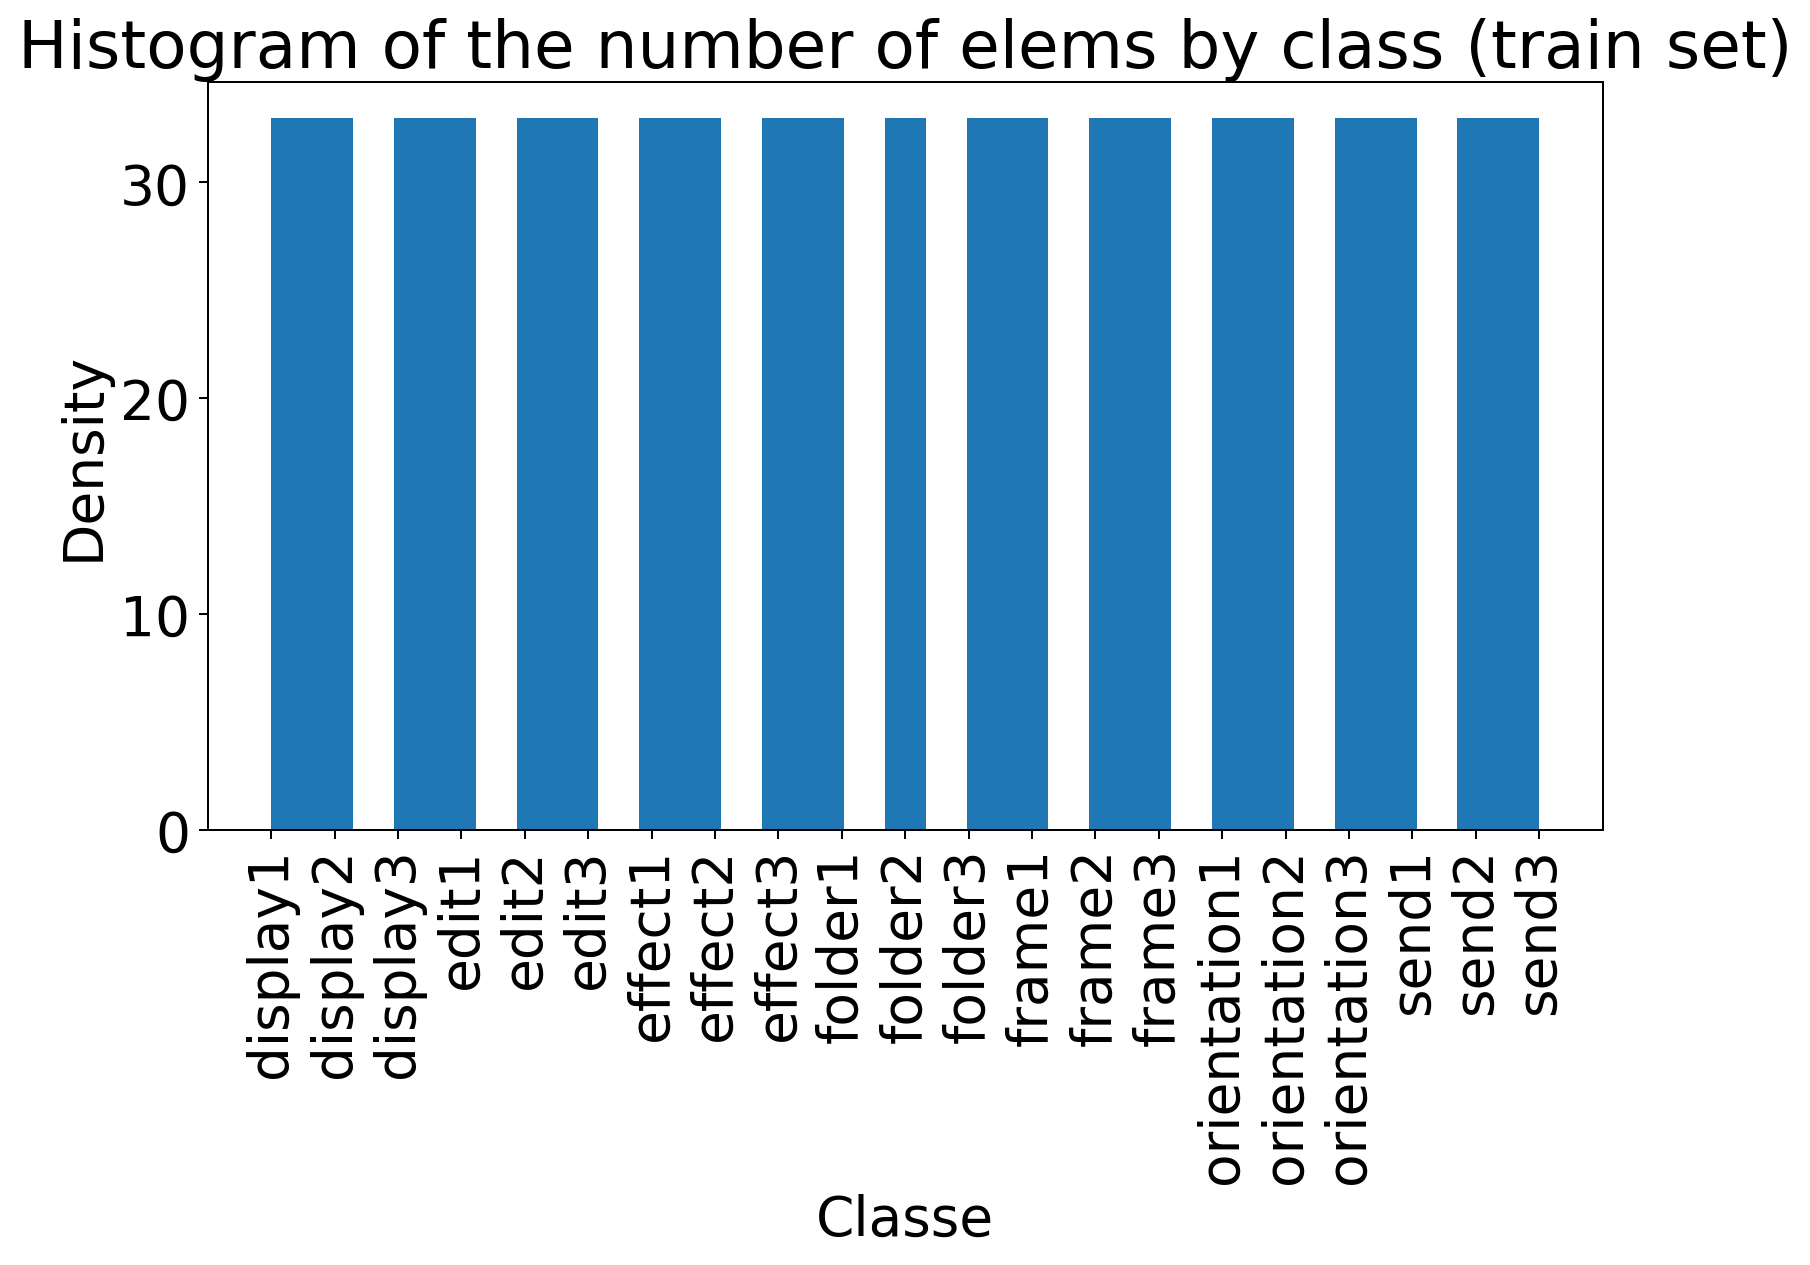

In [6]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)

density, bin, _ = plt.hist(labelsTrain,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (train set)')
# count = [len(gesture[0]) for gesture in gesturesSegmentsTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (test set)')

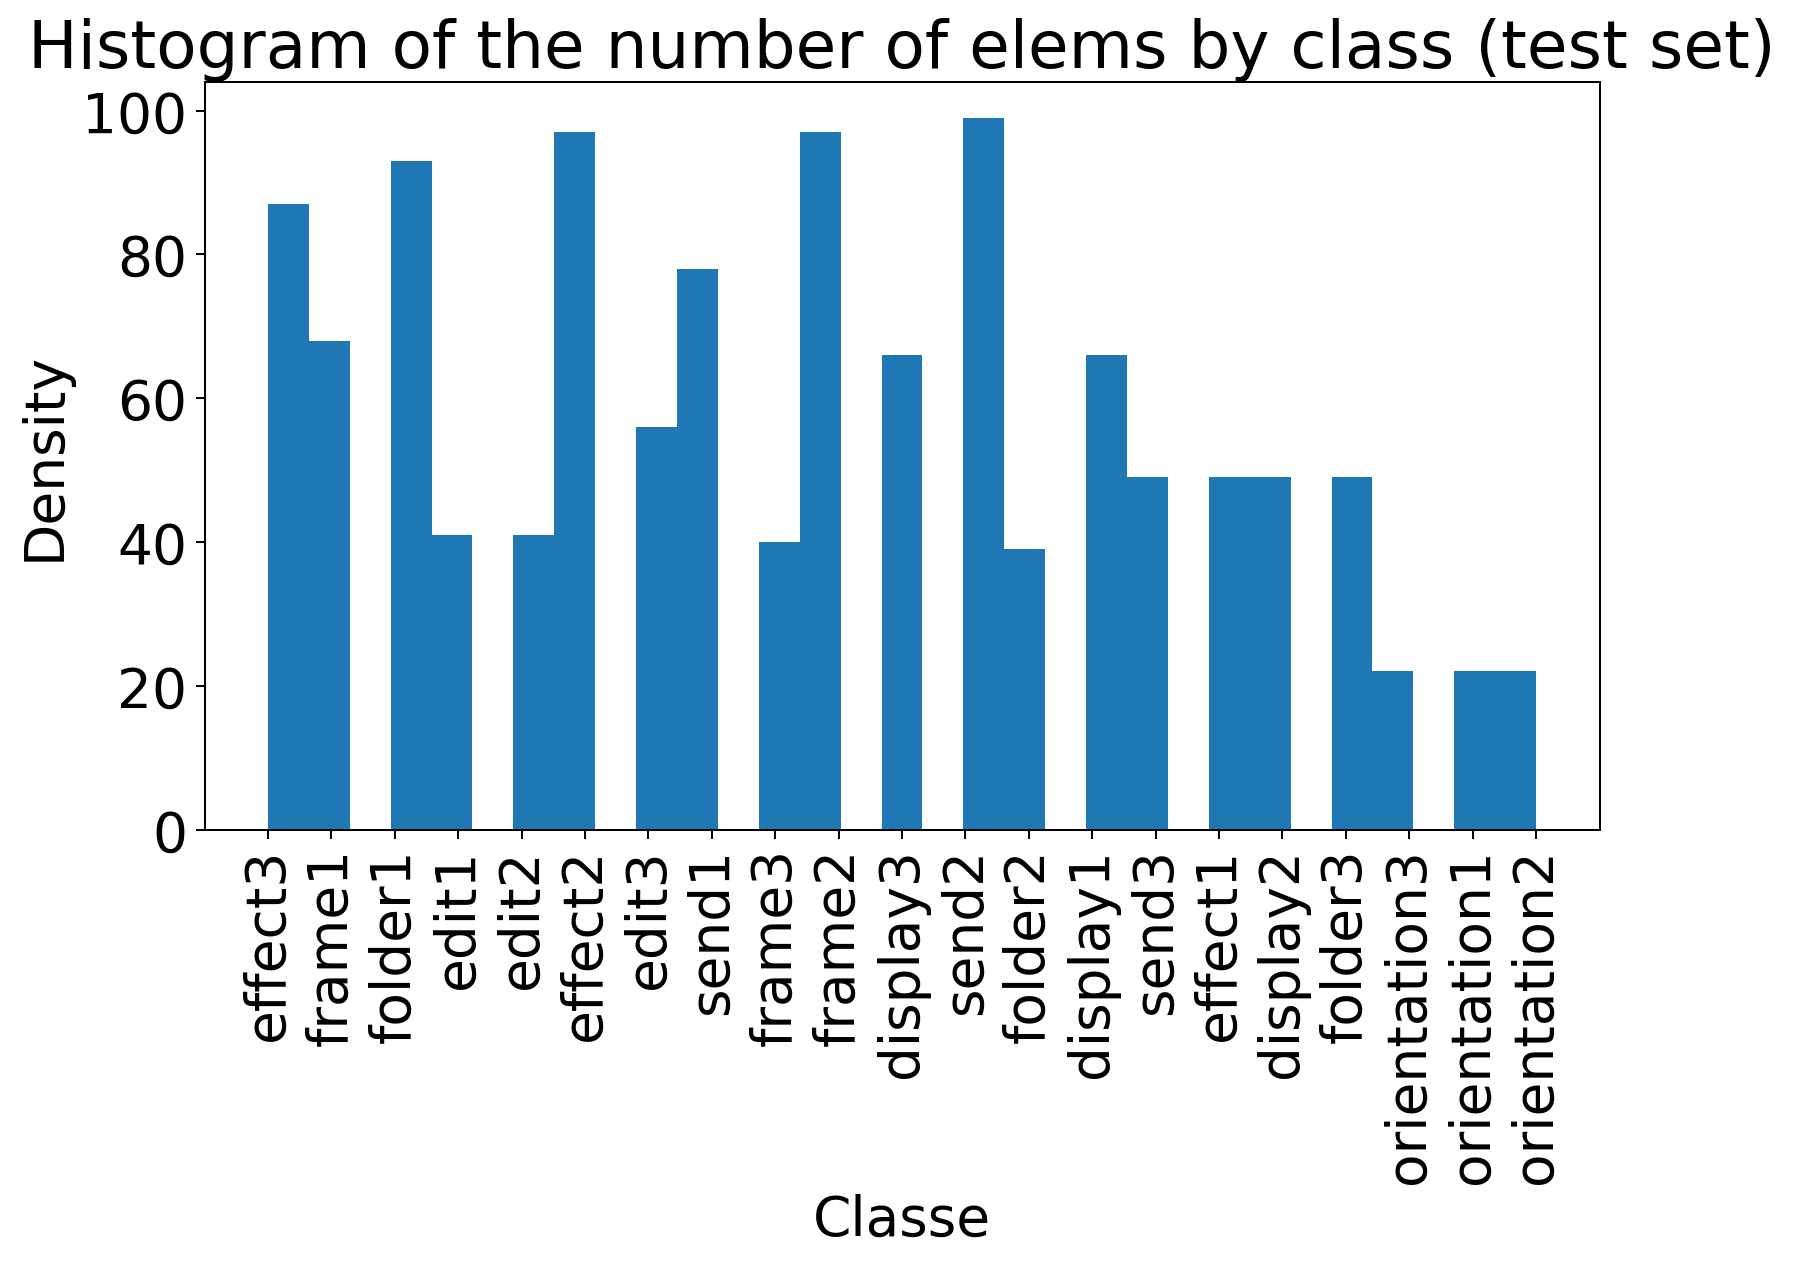

In [7]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)
_, _, _ = plt.hist(labelsTest,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (test set)')

In [8]:
def cumulateGesturesRandomly(gestures: List[Tuple[List[Tuple[float,float,float]],str]],
                             nbGesturePerSequence)->List[Tuple[List[Tuple[float,float,float]],List[Tuple[str,int,int]]]]:
    """

    :param gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]]
    """
    listeOfRemainingIndexes = list(range(0,len(gestures)))
    SequencesOfGestures : List[Tuple[List[Tuple[float,float,float]],List[Tuple[str,int,int]]]] = []
    lastPointCoord = (0,0)
    while len(listeOfRemainingIndexes)>0:
        nbGesturePerSequenceToUse = random.randint(nbGesturePerSequence-2,nbGesturePerSequence+2)
        points : List[Tuple[float,float,float]] = []
        classNameStartEndStrokes:List[Tuple[str,int,int]] = []

        i=0
        while i<nbGesturePerSequenceToUse and len(listeOfRemainingIndexes)>0:
            indexChosen =  random.randint(0,len(listeOfRemainingIndexes)-1)
            gestureIndex = listeOfRemainingIndexes[indexChosen]
            offset = gestures[gestureIndex][0][0][0]-lastPointCoord[0],\
                     gestures[gestureIndex][0][0][1]-lastPointCoord[1] #compute the offset to link two gestures
            listeOfRemainingIndexes.remove(gestureIndex)
            classNameStartEndStrokes += [(gestures[gestureIndex][1],len(points),len(points)+len(gestures[gestureIndex][0])-1)]
            points += [ (p[0]-offset[0],p[1]-offset[1],p[2]) for p in gestures[gestureIndex][0]]
            lastPointCoord = points[-1][0],points[-1][1]
            i+=1
        SequencesOfGestures.append((points, classNameStartEndStrokes))
    return SequencesOfGestures

In [9]:
random.seed(5)
gesturesTest:List[Tuple[List[Tuple[float,float,float]],List[Tuple[str,int,int]]]] = cumulateGesturesRandomly(gesturesTest,6)
FullTrainSet:List[Tuple[List[Tuple[float,float,float]],List[Tuple[str,int,int]]]] = []
FullTrainSet += cumulateGesturesRandomly(gesturesTrain,6)
# FullTrainSet += cumulateGesturesRandomly(gesturesTrain,6)
# FullTrainSet += cumulateGesturesRandomly(gesturesTrain,6)
# FullTrainSet += cumulateGesturesRandomly(gesturesTrain,6)
# FullTrainSet += cumulateGesturesRandomly(gesturesTrain,6)

print(len(gesturesTest))

210


In [10]:
print(len(FullTrainSet))

119


In [11]:
gesture:Tuple[List[Tuple[float,float,float]],List[Tuple[str,int,int]]]
def export(set,folder):
    for i,gesture in enumerate(set):
        points:List[Tuple[float,float,float]] = gesture[0]
        labels:List[Tuple[str,int,int]] = gesture[1]

        point:Tuple[float,float,float]
        chaine = ""
        for iPoint,point in enumerate(points):
            x_y_z = str(iPoint)+";"+" ".join(map(str,point))
            chaine+=x_y_z+"\n"

        chaine += "#####Labels#####"+"\n"
        label:Tuple[str,int,int] #class,start,end
        for label in labels:
            classe_start_end = ",".join(map(str,label))
            chaine += classe_start_end + "\n"

        f = open(pathOutputData+folder+separator+"sequence"+str(i)+".ptc","w+")
        f.write(chaine)
        f.close()

In [12]:
export(FullTrainSet,"Train")
export(gesturesTest,"Test")